In [1]:
import streamlit as st
from PIL import Image
import torch
from model import load_model1, load_model2, load_model3, load_model4
import torchvision.transforms as transforms
import io
import base64

In [85]:
def transform_image(image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])
    return transform(image).unsqueeze(0)  # Add batch dimension

def generate_transformed_image(model, image_tensor):
    with torch.no_grad():
        output = model(image_tensor)
    output = output.squeeze().cpu().detach().numpy()
    output = (output * 0.5) + 0.5  # De-normalize
    output = output.transpose(1, 2, 0)
    return Image.fromarray((output * 255).astype('uint8'))

def image_to_base64(image):
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode()

In [3]:
# Load the models
model_winter_to_summer1 = load_model1("model1_winter_to_summer.pth")  # With distillation
model_winter_to_summer2 = load_model2("model2_winter_to_summer.pth")  # Without distillation
model_summer_to_winter3 = load_model3("model3_summer_to_winter.pth")  # With distillation
model_summer_to_winter4 = load_model4("model4_summer_to_winter.pth")  # Without distillation
print('models loaded')

models loaded


In [40]:
# # example of calculating the frechet inception distance
# import numpy
# from numpy import cov
# from numpy import trace
# from numpy import iscomplexobj
# from numpy.random import random
# from scipy.linalg import sqrtm

# # calculate frechet inception distance
# def calculate_fid(act1, act2):
# 	# calculate mean and covariance statistics
# 	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
# 	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
# 	# calculate sum squared difference between means
# 	ssdiff = numpy.sum((mu1 - mu2)**2.0)
# 	# calculate sqrt of product between cov
# 	covmean = sqrtm(sigma1.dot(sigma2))
# 	# check and correct imaginary numbers from sqrt
# 	if iscomplexobj(covmean):
# 		covmean = covmean.real
# 	# calculate score
# 	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
# 	return fid

# # define two collections of activations
# act1 = random(10*2048)
# act1 = act1.reshape((10,2048))
# act2 = random(10*2048)
# act2 = act2.reshape((10,2048))
# # fid between act1 and act1
# fid = calculate_fid(act1, act1)
# print('FID (same): %.3f' % fid)
# # fid between act1 and act2
# fid = calculate_fid(act1, act2)
# print('FID (different): %.3f' % fid)

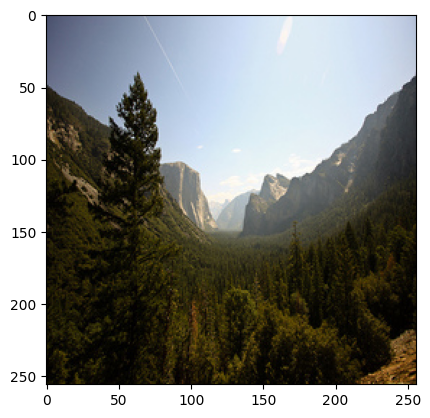

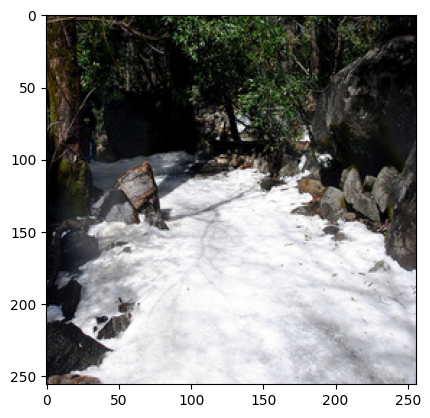

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

test_img_summer = cv2.imread("../../Summer@Winter/archive/testA/2010-09-07 12_23_20.jpg")
test_img_summer_rgb = cv2.cvtColor(test_img_summer, cv2.COLOR_BGR2RGB)

plt.imshow(test_img_summer_rgb)
plt.show()

test_img_winter = cv2.imread("../../Summer@Winter/archive/testB/2006-04-11 11_21_20.jpg")
test_img_winter_rgb = cv2.cvtColor(test_img_winter, cv2.COLOR_BGR2RGB)

plt.imshow(test_img_winter_rgb)
plt.show()

In [135]:
summer_img_1 = Image.open("../../Summer@Winter/archive/testA/2010-09-07 12_23_20.jpg")
summer_img_2 = Image.open("../../Summer@Winter/archive/testA/2011-05-26 15_06_01.jpg")

summer_img_1_transformed = transform_image(summer_img_1)
summer_img_2_transformed = transform_image(summer_img_2)

In [136]:
winter_img_1 = Image.open("../../Summer@Winter/archive/testB/2006-04-11 11_21_20.jpg")
winter_img_2 = Image.open("../../Summer@Winter/archive/testB/2006-08-26 18_17_00.jpg")

winter_img_1_transformed = transform_image(winter_img_1)
winter_img_2_transformed = transform_image(winter_img_2)

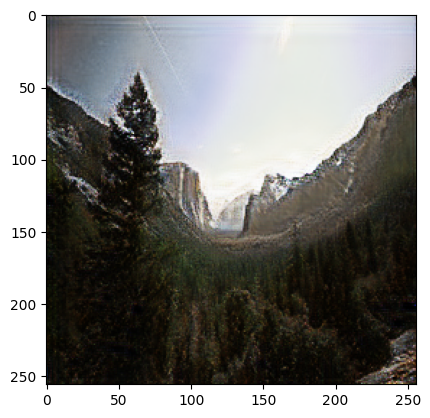

In [174]:
winter_pred_1 = generate_transformed_image(model_summer_to_winter4, summer_img_1_transformed)

plt.imshow(winter_pred_1)

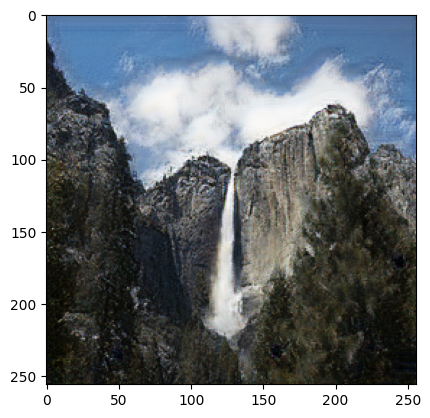

In [175]:
winter_pred_2 = generate_transformed_image(model_summer_to_winter4, summer_img_2_transformed)

plt.imshow(winter_pred_2)

---

In [99]:
from tensorflow.keras.applications import InceptionV3

# load inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# model.summary()

In [100]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
from skimage.transform import resize

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)

In [102]:
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)

    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real

    epsilon = 1e-6
    covmean = covmean + epsilon * numpy.eye(covmean.shape[0])
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [176]:
images1 = np.array(summer_img_1)
images2 = np.array(winter_pred_1)

images1 = np.expand_dims(images1, axis=0)
images2 = np.expand_dims(images2, axis=0)

temp_images1 = np.array(summer_img_2)
temp_images2 = np.array(winter_pred_2)

temp_images1 = np.expand_dims(temp_images1, axis=0)
temp_images2 = np.expand_dims(temp_images2, axis=0)

images1 = np.concatenate((images1, temp_images1), axis=0)
images2 = np.concatenate((images2, temp_images2), axis=0)

In [177]:
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')

In [178]:
# resize images
images1_scaled = scale_images(images1, (299,299,3))
images2_scaled = scale_images(images2, (299,299,3))

In [179]:
images1_scaled.shape

(2, 299, 299, 3)

In [180]:
# pre-process images
images1 = preprocess_input(images1_scaled)
images2 = preprocess_input(images2_scaled)

In [173]:
# fid between images1 and images1
fid = calculate_fid(model, images2, images2)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
FID (same): -0.004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
FID (different): 38.800


In [181]:
# fid between images1 and images1
fid = calculate_fid(model, images2, images2)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
FID (same): -0.004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
FID (different): 65.827
